In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:

from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from matplotlib.patches import Circle
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
from matplotlib.colors import LogNorm

In [7]:
path = "/data/OWN/SF1test/SF0/mstar1_T3600/output_00041"
path = "/data/OWN/DMO/mochima2/output_00041"
myhalo= wkbl.Galaxy_Hound(path)
print "loaded"
print myhalo.dm.pos3d[:,0].max()
print myhalo.dm.pos3d[:,1].max()
print myhalo.dm.pos3d[:,2].max()

zoom_reg = np.where(myhalo.dm.mass==myhalo.dm.mass.min())
nucenter = nbe.real_center(myhalo.dm.pos3d[zoom_reg], myhalo.dm.mass[zoom_reg])
print nucenter
"""
myhalo.center_shift(nucenter)
myhalo.r_virial(600)
print "cutted"
nucenter = nbe.real_center(myhalo.dm.pos3d, myhalo.dm.mass)
myhalo.center_shift(nucenter)
myhalo.redefine(4.5)

"""

loading Dark matter..
loaded
36842.52
36842.523
36842.516
[20424.32439682 17577.97142812 17119.95067264]


'\nmyhalo.center_shift(nucenter)\nmyhalo.r_virial(600)\nprint "cutted"\nnucenter = nbe.real_center(myhalo.dm.pos3d, myhalo.dm.mass)\nmyhalo.center_shift(nucenter)\nmyhalo.redefine(4.5)\n\n'

In [6]:
print nucenter / myhalo.p.simutokpc

[0.55436804 0.47711083 0.46467902]


In [13]:
vol = (myhalo.p.boxlen*1e3)**3
mass = np.sum(myhalo.st.mass)+np.sum(myhalo.dm.mass)+np.sum(myhalo.gs.mass)
expected_mass = vol*myhalo.p._vars["omega_m"]*myhalo.p.rho_crit
print "mass in simu    = {0:.3e} Msun".format(mass)
print "mass from cosmo = {0:.3e} Msun".format(expected_mass)
print "omega_m = {0:.3f} Msun".format(myhalo.p._vars["omega_m"])


mass in simu    = 6.091e+14 Msun
mass from cosmo = 6.086e+14 Msun
omega_m = 0.309 Msun


In [19]:
print myhalo.p._vars["unit_d"]
print myhalo.p._vars["omega_m"] * myhalo.p.rho_crit *(myhalo.p.H0/100.)**2 / myhalo.p.aexp**3

2.66335723551e-30
17.9525839316


In [21]:
print "r_200    = {0:.2f} kpc".format(myhalo.r200)
print "boxlen   = {0:.2f} Mpc".format(myhalo.p.boxlen)
print "M_dm_200 = {0:.2e} Msun".format(np.sum(myhalo.dm.mass[myhalo.dm.r<myhalo.r200]))
print "M_st_200 = {0:.2e} Msun".format(np.sum(myhalo.st.mass[myhalo.st.r<myhalo.r200]))
print "M_st_200 = {0:.2e} Msun".format(np.sum(myhalo.st.mass[myhalo.st.r<17]))


r_200    = 144.73 kpc
boxlen   = 24.96 Mpc
M_dm_200 = 2.56e+11 Msun
M_st_200 = 3.65e+10 Msun
M_st_200 = 3.45e+10 Msun


In [22]:
ok,myhalo.dm.rho,_= CF.getDensity(np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),
                                    dtype=np.float32), myhalo.dm.mass)


In [23]:
ok,myhalo.st.rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),
                                    dtype=np.float32), myhalo.st.mass)

In [24]:
myhalo.r200

144.7265625

<IPython.core.display.Javascript object>


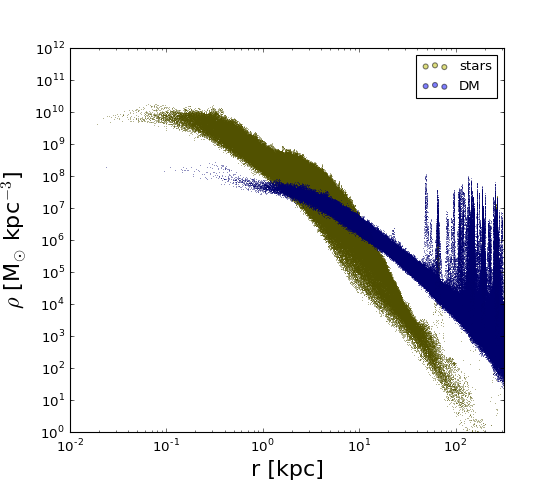

/usr/lib/python2.7/dist-packages/matplotlib/legend.py:325: UserWarning: Unrecognized location "bottom left". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  six.iterkeys(self.codes))))


In [25]:
fig, ax= plt.subplots(figsize=[7,6])
ax.set_xlim([1e-2,10**2.5])
ax.set_ylim([1,1e12])
ax.scatter(myhalo.st.r, myhalo.st.rho,s=0.5,alpha=0.5,lw=0,c='y')
ax.scatter(1e20,1e20,c='y',alpha=0.5, label="stars")
ax.scatter(1e20,1e20,c='b',alpha=0.5, label="DM")

ax.scatter(myhalo.dm.r, myhalo.dm.rho,s=0.5,alpha=0.5,lw=0)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e0,1e12])
ax.set_xlabel(r"r [kpc]",fontsize=20)
ax.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)
ax.set_title("",fontsize=15)
####
legend = ax.legend(loc='bottom left', ncol=1, shadow=False, fontsize=12)

In [28]:
def face_on_dm(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.dm.pos3d[:,0], 
                                       sim.dm.pos3d[:,1],
                                       bins=(edges, edges),
                                       weights=sim.dm.mass)
    result = H.T
    return result, edges

def face_on_st(sim,lims,points,thikness=.5):
    disk = (np.abs(sim.st.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[disk,0], 
                                       sim.st.pos3d[disk,1],
                                       bins=(edges, edges),
                                       weights=sim.st.mass[disk])
    result = H.T
    return result, edges

def face_on_gs(sim,lims,points,thikness=.9):
    disk = (np.abs(sim.gs.pos3d[:,2])<thikness)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[disk,0], 
                                       sim.gs.pos3d[disk,1],
                                       bins=(edges, edges),
                                       weights=sim.gs.mass[disk])
    result = H.T
    return result, edges

def edge_on_st(sim,lims,points):
    #disk = sim.st.pos3d[:,2]
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[:,0], 
                                       sim.st.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=sim.st.mass)
    result = H.T
    return result, edges
    
def edge_on_gs(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.gs.pos3d[:,0], 
                                       sim.gs.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=sim.gs.mass)
    result = H.T
    return result, edges
    

In [29]:
# Moster et all
def M_1(z):
    M10 ,M11 = 11.590, 1.195
    log = M10 + M11*(z / (z+1))
    return 10**(log)

def N(z):
    N10 ,N11 = 0.0351, -0.0247
    return N10 + N11*(z / (z+1))


def beta(z):
    B10 ,B11 = 1.376, -0.826
    return B10 + B11*(z / (z+1))


def gamma(z):
    G10 ,G11 = 0.608, 0.329
    return G10 + G11*(z / (z+1))

def mm(M,z=0):
    one = ( M / M_1(z))**(-beta(z))
    two = ( M / M_1(z))**gamma(z)
    return 2*N(z) * M / (one +two)

def alpha(m):
    return 0.15 / np.log10(m)

M = np.logspace(10,14,50)
m = mm(M)
al = np.sqrt(m)#alpha(m)

<IPython.core.display.Javascript object>


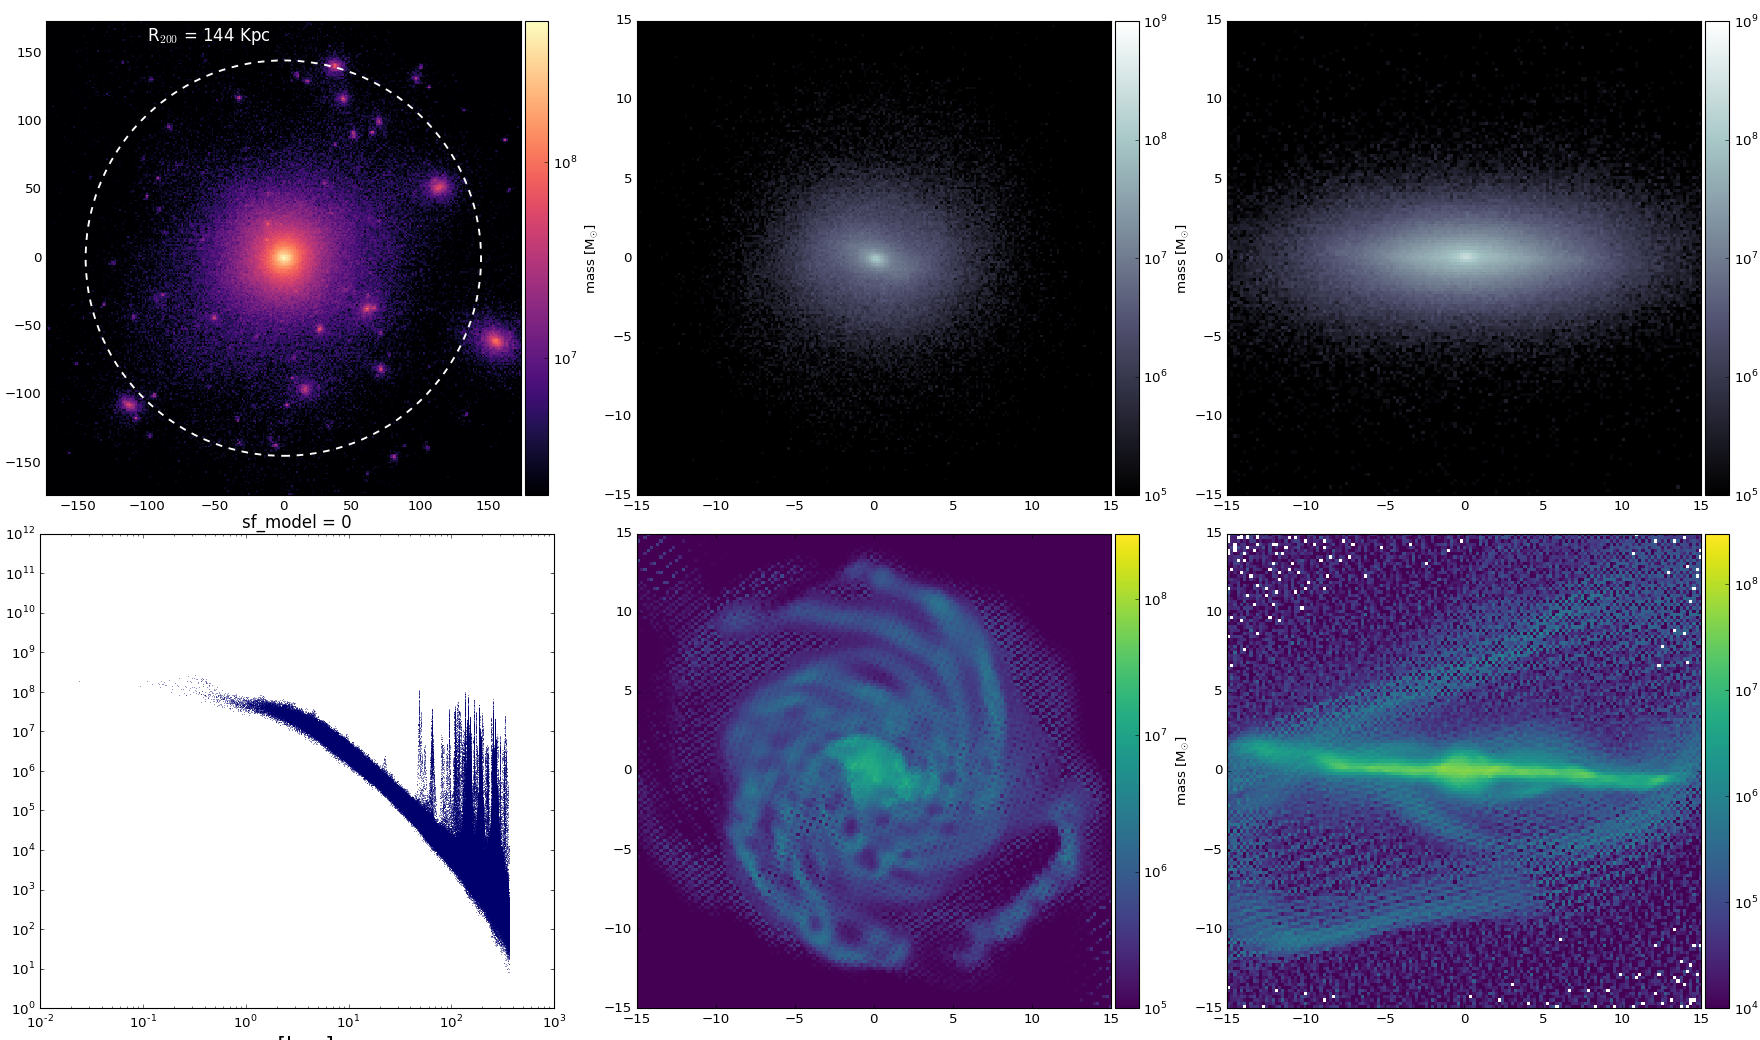

In [36]:

SF130_faceon, edges = face_on_dm(myhalo,[-1.2*myhalo.r200,1.2*myhalo.r200],300)
length = 15. 
fig,[[ax,ax1,ax2],[ax3,ax4,ax5]] = plt.subplots(2,3,figsize=[22,13])
fig.tight_layout(w_pad=3)

#######################################################################################################################3
mass_1 = ax.imshow(SF130_faceon+1e3, interpolation='nearest', origin='low',cmap="magma",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=2e6)
                  )
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')

ax.add_artist(Circle(xy=(0, 0),radius=myhalo.r200,color='w',ls='--',lw=1.7,fill=False))
ax.text(-100,1.1*myhalo.r200,r"R$_{200}$ = "+str(int(myhalo.r200))+" Kpc ",color='w',fontsize=15)
#######################################################################################################################3

SF1140_faceOn,edges = face_on_st(myhalo,[-length,length],200)#H.T 

mass_2 = ax1.imshow(SF1140_faceOn+1e3, interpolation='nearest', origin='low',cmap="bone",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=1e9)
                  )

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')
#######################################################################################################################3

SF1140_edgeOn,edges = edge_on_st(myhalo,[-length,length],150)#H.T 


mass_2 = ax2.imshow(SF1140_edgeOn+1e3, interpolation='nearest', origin='low',cmap="bone",
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=1e9)
                  )

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

SF1140_faceOn,edges= face_on_gs(myhalo,[-length,length],150)#H.T 

mass_2 = ax4.imshow(SF1140_faceOn+1e5, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=3e8)
                  )

divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')

#######################################################################################################################3

SF1140_edgeOn,edges = edge_on_gs(myhalo,[-length,length],150)#H.T 


mass_2 = ax5.imshow(SF1140_edgeOn, interpolation='nearest', origin='low',cmap='viridis',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e4,vmax=3e8)
                  )

divider = make_axes_locatable(ax5)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'mass [M$_{\odot}$]')


ax3.scatter(myhalo.dm.r, myhalo.dm.rho,s=0.5,alpha=0.5,lw=0)
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_ylim([1e0,1e12])
ax3.set_xlabel(r"r [kpc]",fontsize=20)
ax3.set_ylabel(r"$\rho$ [M$_{\odot}$ kpc$^{-3}$]",fontsize=20)
ax3.set_title("sf_model = 0",fontsize=15)

In [37]:
myhalo.gs.hsml.min()

0.19045308

<IPython.core.display.Javascript object>


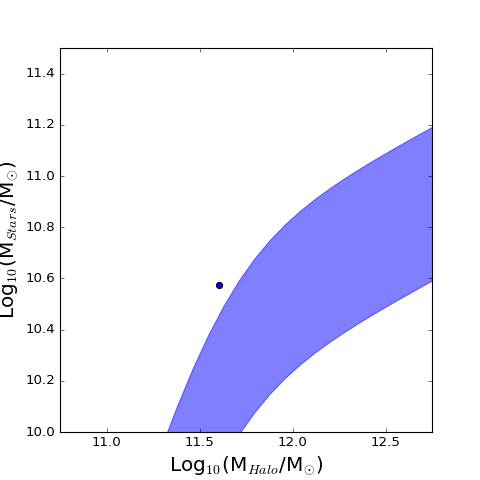

11.603187 10.575375


In [40]:
fig, ax = plt.subplots(figsize = [6,6])
ax.set_xlim(10.75,12.75)
ax.set_ylim(10,11.5)
ax.set_xlabel(r'Log$_{10}$(M$_{Halo}$/M$_{\odot}$)',fontsize=18)
ax.set_ylabel(r'Log$_{10}$(M$_{Stars}$/M$_{\odot}$)',fontsize=18)

ax.fill_between(np.log10(M), np.log10(m)+.3,np.log10(m)-.3,color='blue',alpha=0.5 )
x = 0.03
y = -.02
#ax.scatter(np.log10(SF1_30.dm.total_m),np.log10(SF1_30.st.total_m),marker='s',c='r',s=30)
#ax.text(np.log10(SF1_30.dm.total_m)+x,np.log10(SF1_30.st.total_m)+y,'30 Myr',fontsize=13)
#ax.scatter(np.log10(SF1_90.dm.total_m),np.log10(SF1_90.st.total_m),marker='^',c='g',s=30)
#ax.text(np.log10(SF1_90.dm.total_m)+x,np.log10(SF1_90.st.total_m)+y,'90 Myr',fontsize=13)
ax.scatter(np.log10(myhalo.dm.total_m),np.log10(myhalo.st.total_m),marker='o',c='b',s=30)
print np.log10(myhalo.dm.total_m),np.log10(myhalo.st.total_m)
#ax.text(np.log10(myhalo.dm.total_m)+x,np.log10(myhalo.st.total_m)+y,'140 Myr',fontsize=13)
#ax.scatter(np.log10(SF0.dm.total_m),np.log10(SF0.st.total_m),marker='>',c='m',s=30)
#ax.text(np.log10(SF0.dm.total_m)+x,np.log10(SF0.st.total_m)+y,'Old Star Formation',fontsize=13)


In [41]:
r_arr = np.arange(0,30,30./100.)
_= np.histogram(myhalo.dm.r,bins=r_arr,weights=myhalo.dm.vtheta)



In [42]:

pos_dm = np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(myhalo.gs.pos3d.reshape(len(myhalo.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
mass = np.concatenate((myhalo.dm.mass,myhalo.st.mass,myhalo.gs.mass))
v = np.concatenate((myhalo.dm.v,myhalo.st.v,myhalo.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

9759609 9759609


In [43]:

def circular_speed(r,comp="all"):
    if comp=='all': 
        m = mass
        radii = np.sqrt(r2)
    elif comp=="dm":
        m = myhalo.dm.mass
        radii = myhalo.dm.r
    elif comp=="st":
        m = myhalo.st.mass
        radii = myhalo.st.r
    elif comp=="gs":
        m = myhalo.gs.mass
        radii = myhalo.gs.r
    else:
        sys.exit("no valid component")
    enclosed_m = np.sum(m[np.where(radii<r)])
    return np.sqrt(myhalo.p.G * enclosed_m / r) * myhalo.p.kpctokm

get_vc= np.vectorize(circular_speed)
r = np.linspace(0,40,60)
vc_all = get_vc(r,comp='all')
vc_dm = get_vc(r,comp='dm')
vc_st = get_vc(r,comp='st')
vc_gs = get_vc(r,comp='gs')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [44]:
vc_stars_vphi = np.array([])
std_stars_vphi = np.array([])
vc_gas_vphi = np.array([])
std_gas_vphi = np.array([])
for i in range(len(r)-1):
    stars_condition = (myhalo.st.R>r[i])&(myhalo.st.R<r[i+1])&(np.abs(myhalo.st.pos3d[:,2])<0.5)
    gas_condition = (myhalo.gs.R>r[i])&(myhalo.gs.R<r[i+1])&(np.abs(myhalo.gs.pos3d[:,2])<0.5)
    vc_gas_vphi = np.append(vc_gas_vphi, np.average(myhalo.gs.vphi[gas_condition]))
    std_gas_vphi = np.append(std_gas_vphi, np.std(myhalo.gs.vphi[gas_condition]))
    #for stars
    vc_stars_vphi = np.append(vc_stars_vphi, np.nanmean(myhalo.st.vphi[stars_condition]))
    std_stars_vphi = np.append(std_stars_vphi, np.nanstd(myhalo.st.vphi[stars_condition]))
r_arrays = (r[1:] + r[:-1]) / 2.

In [45]:
file = open("../vcdata.dat")
R_mw = np.array([])
R_err = np.array([])
vc_mw = np.array([])
vc_err = np.array([])

for ln in file:
    row = ln.split('\t')
    if row[0][0]=='#':
        continue
    R_mw = np.append(R_mw, row[0])
    R_err = np.append(R_err, row[1])
    vc_mw = np.append(vc_mw, row[2])
    vc_err = np.append(vc_err, row[3])
print vc_err    

['4.5' '4.5' '4.5' ... '19.8466566348' '19.7816973913' '23.7338181969']


<IPython.core.display.Javascript object>


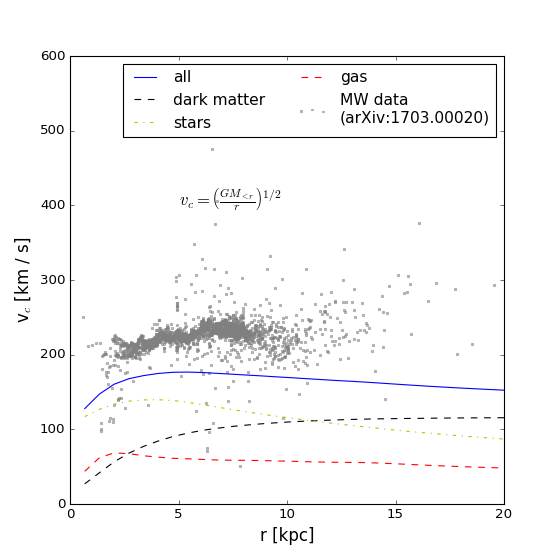

2590 2590


In [46]:
fig, ax = plt.subplots(figsize=[7,7])
ax.set_ylim(0,600)
ax.set_xlim(0,20)
ax1.set_xlim(0,20)


print len(vc_mw),len(vc_err)
ax.scatter(R_mw,vc_mw,color='gray',marker='s',alpha=0.5,s=2,label="MW data\n(arXiv:1703.00020)")
ax.plot(r, vc_all,'b-',label='all')
ax.plot(r, vc_dm, 'k--',label='dark matter')
ax.plot(r, vc_st, 'y-.',label='stars')
ax.plot(r, vc_gs ,'r--',label='gas')
texto  = r"$v_c = \left(\frac{G M_{<r}}{r}\right)^{1/2}$"
ax.text(5,400,texto,fontsize=15)
ax.set_xlabel("r [kpc]",fontsize=15)
ax.set_ylabel(r"v$_{c}$ [km / s]",fontsize=15)
legend = ax.legend(loc='upper right', ncol=2, shadow=False, fontsize=14)
frame = legend.get_frame()
ax1.set_ylim(-200,700)
ax1.plot(r_arrays,-vc_stars_vphi+std_stars_vphi,'r--')
ax1.plot(r_arrays,-vc_stars_vphi-std_stars_vphi,'r--')
ax1.fill_between(r_arrays,-vc_stars_vphi+std_stars_vphi, -vc_stars_vphi-std_stars_vphi,color='r',alpha=0.2)
ax1.plot(r_arrays,-vc_stars_vphi,'ro-',markersize=4,markeredgewidth=0,
         label=r"$\left<v_{\phi}\right>_{stars} \pm 1 \sigma$ ")
ax1.plot(r_arrays,-vc_gas_vphi-std_gas_vphi,'g--')
ax1.plot(r_arrays,-vc_gas_vphi+std_gas_vphi,'g--')
ax1.fill_between(r_arrays,-vc_gas_vphi+std_gas_vphi, -vc_gas_vphi-std_gas_vphi,color='g',alpha=0.2)
texto_dos = "cylindric rings of\n"
texto_dos += r"$|z| <  0.5$ kpc"
ax1.text(5,400,texto_dos,fontsize=15)
ax1.scatter(R_mw,vc_mw,color='gray',marker='s',alpha=0.5,s=2)

ax1.plot(r_arrays,-vc_gas_vphi,'go-',markersize=4,markeredgewidth=0,label=r"$\left<v_{\phi}\right>_{gas}\pm 1 \sigma$")

ax1.plot(r,vc_all,'b-',label=r"$v_c = \left(\frac{G M_{<r}}{r}\right)^{1/2}$")

ax1.set_xlabel("r [kpc]",fontsize=15)
ax1.set_ylabel(r"v$_{c}$ [km / s]",fontsize=15)
legend = ax1.legend(loc='upper right', ncol=2, shadow=False, fontsize=15)
frame = legend.get_frame()
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/report07-17/HaloB/circularSpeedsCilyndric.pdf")

In [47]:
# total stellar mass inside 0.1*r97
Mstar = np.sum(myhalo.st.mass[myhalo.st.r < (myhalo.r97/10.)])
# wheighted histogram of mass as the radius grows
hist = np.histogram(myhalo.st.r[myhalo.st.r < (myhalo.r97/10.)],bins=5012,
             weights=myhalo.st.mass[myhalo.st.r < (myhalo.r97/10.)])
# find radius wher 80% of the stellar mass is contained
"""
note that this radius is decided like that by mollitor because
in his sim the rotatioon curve are already flat, in our case this does
not happens..
"""
r_80 = hist[1][np.argmin(np.abs((np.cumsum(hist[0])/hist[0].sum())-0.8))]
# circular speed
v_rot = circular_speed(r_80)

<IPython.core.display.Javascript object>


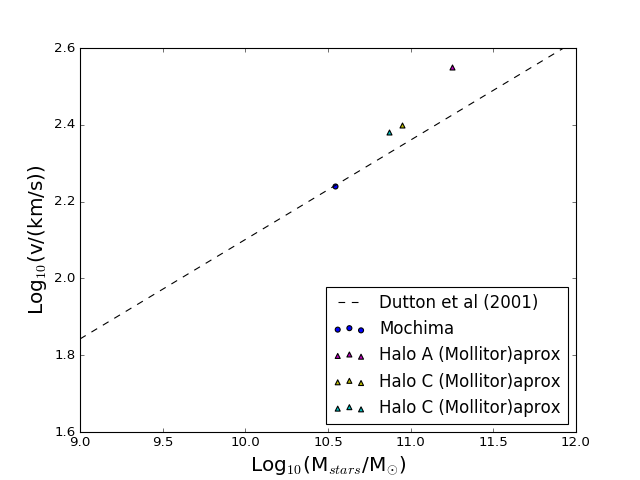

10.543006 2.239494485845688


In [48]:

fig, ax = plt.subplots()
ax.set_xlim(9,12)
ax.set_ylim(1.6,2.6)
ax.set_xlabel(r"Log$_{10}$(M$_{stars}$/M$_{\odot}$)",fontsize=18)
ax.set_ylabel(r"Log$_{10}$(v/(km/s))",fontsize=18)
x = np.arange(9.,14,0.2)
ax.plot(x, 2.179+(x-10.3)*0.259,"k--",label="Dutton et al (2001)")
ax.scatter(np.log10(Mstar),np.log10(v_rot),label="Mochima")
print np.log10(Mstar),np.log10(v_rot)
ax.scatter(11.25,2.55,color="m",marker="^",edgecolor="k",label="Halo A (Mollitor)aprox")
ax.scatter(10.95,2.4,color="y",marker="^",edgecolor="k",label="Halo C (Mollitor)aprox")
ax.scatter(10.87,2.38,color="c",marker="^",edgecolor="k",label="Halo C (Mollitor)aprox")
legend = ax.legend(loc='lower right', ncol=1, shadow=False, fontsize=15)
frame = legend.get_frame()



In [49]:
h=0.673
H0 = h/0.9777
def t_z(z):
    return (2./3./H0)*(1-(1/(1+z)**(1.5)))

print t_z(3)

0.847436849926


<IPython.core.display.Javascript object>


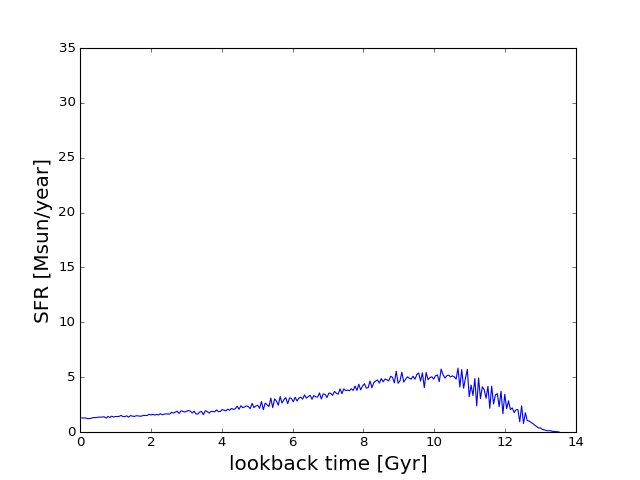

In [5]:

age_hist = np.histogram(myhalo.st.age,bins=256,weights=myhalo.st.mass)
fig,ax = plt.subplots()
ax.set_ylim([0,35])
ax.set_ylabel("SFR [Msun/year]", fontsize=18)
ax.set_xlabel("lookback time [Gyr]", fontsize=18)
thikness=age_hist[1][1]-age_hist[1][0]

ax.plot(-1*age_hist[1][:-1],age_hist[0]/(thikness*1e9))


In [44]:
,print myhalo.p.unitt

myhalo.p.unitt
